In [1]:
# Import packages
import json

import requests
import pandas as pd
pd.options.display.max_columns = None

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Ingest to df
resp = requests.get('https://pomber.github.io/covid19/timeseries.json')
resp_json_str = resp.text
resp_dict = json.loads(resp_json_str)
l = []
for c, cl in resp_dict.items():
    for d in cl:
        d.update({'country' : c})
        l.append(d)
df = pd.DataFrame(l)

# Filter, transform


In [3]:
# Filter & Transform
ASEAN_COUNTRIES = ['Singapore', 'Thailand', 'Malaysia', 'Indonesia', 'Vietnam', 'Cambodia', 'Philippines', 'Brunei']
asean_dfs = []
for c in ASEAN_COUNTRIES:
    df_c = df[df.country==c].copy()
    df_c['date'] = pd.to_datetime(df_c['date'], format='%Y-%m-%d')
    df_c['date'] = df_c['date'].dt.strftime('%Y-%m-%d')
    df_c['date'] = df_c['date'].astype(str)
    # Feature: New cases
    df_c['confirmed_tm1'] = df_c['confirmed'].shift(1)
    df_c['confirmed_tm1'] = df_c['confirmed_tm1'].fillna(0)
    df_c['confirmed_tm1'] = df_c['confirmed_tm1'].astype(int)
    df_c['new'] = df_c['confirmed'] - df_c['confirmed_tm1']
    # Feature: Currently Hospitalised
    df_c['live'] = df_c['confirmed'] - df_c['recovered']
    _ = df_c.reset_index(drop=True, inplace=True)
#     print(c)
#     display(df_c[['date', 'new', 'confirmed', 'live', 'recovered']].sort_values('date', ascending=True).tail(10).T)
#     print(df_c.shape)
#     print()
#     print()
    asean_dfs.append((c, df_c))

In [4]:
# 2nd graph, used for highlighting DORSCON Orange
x = np.arange(df_c.shape[0])
df2 = pd.DataFrame({'x' : x, 'y' : 0})

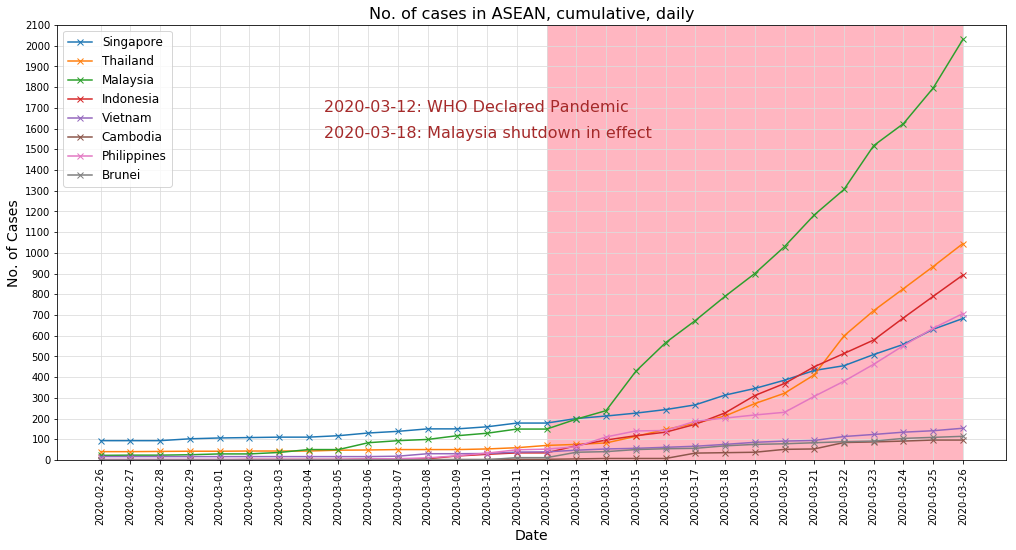

In [5]:
LAST_DAYS = 30
Y_SIZE = 100

fig = plt.figure(figsize=(17,8))
ax = fig.add_subplot(1,1,1)
ds = []
d_max_vals = []
for (d, df_d) in asean_dfs:
    # Plot
    df_d.tail(LAST_DAYS).plot(kind='line', x='date', y='confirmed', ax=ax, marker='x', linewidth=1.5)
    ds.append(d)
    d_max_vals.append(df_d.tail(LAST_DAYS)['confirmed'].max())
# df2.tail(LAST_DAYS).plot(kind='line', x='x', y='y', ax=ax, linewidth=0)
# x & y axes
ax.set_xticks(range(LAST_DAYS))
ax.set_xticklabels(df_c['date'].tail(LAST_DAYS), rotation=90)
ax.set_xlabel("Date", fontsize=14)

ylim_max = max(d_max_vals)
ylim_max = (ylim_max//Y_SIZE + 1)*Y_SIZE

ax.set_ylim(0, ylim_max)
ax.set_yticks(range(0,ylim_max+1,Y_SIZE))
ax.set_ylabel("No. of Cases", fontsize=14)
ax.grid(color='GAINSBORO')
ax.legend(ds, fontsize=12)

# WHO Declares Pandemic
df_c_t = df_c.tail(LAST_DAYS).copy()
_ = df_c_t.reset_index(inplace=True, drop=True)
pdm_start_index = df_c_t[df_c_t.date=='2020-03-12'].index[0]
ax.fill_between([pdm_start_index,df_c_t.index.max()], 0, ylim_max, facecolor='LIGHTPINK')
ax.text(pdm_start_index*0.5, ylim_max*0.80,"2020-03-12: WHO Declared Pandemic", fontsize=16, color="BROWN")
ax.text(pdm_start_index*0.5, ylim_max*0.74,"2020-03-18: Malaysia shutdown in effect", fontsize=16, color="BROWN")

ax.set_title("No. of cases in ASEAN, cumulative, daily", fontsize=16)
plt.show()

In [6]:
pivot_raw = df[(df.country.isin(ASEAN_COUNTRIES)) & (df.date.isin(df['date'].unique()[-int(LAST_DAYS/3):]))][['country', 'date', 'confirmed']]
pivot_raw = pivot_raw.copy()
pd.pivot_table(pivot_raw, columns=['date'], index='country')

confirmed                                                    \
date        2020-3-17 2020-3-18 2020-3-19 2020-3-20 2020-3-21 2020-3-22   
country                                                                   
Brunei             56        68        75        78        83        88   
Cambodia           33        35        37        51        53        84   
Indonesia         172       227       311       369       450       514   
Malaysia          673       790       900      1030      1183      1306   
Philippines       187       202       217       230       307       380   
Singapore         266       313       345       385       432       455   
Thailand          177       212       272       322       411       599   
Vietnam            66        75        85        91        94       113   

                                                     
date        2020-3-23 2020-3-24 2020-3-25 2020-3-26  
country                                              
Brunei             91       104       109       114  
Cambodia           87        91        96        96  
Indonesia         579       686       790       893  
Malaysia         1518      1624      1796      2031  
Philippines       462       552       636       707  
Singapore         509       558       631       683  
Thailand          721       827       934      1045  
Vietnam           123       134       141       153

Sources: 

[Malaysia bars citizens from going overseas, foreigners from entering country for 2 weeks to curb COVID-19 spread: PM Muhyiddin](https://www.channelnewsasia.com/news/asia/malaysia-bars-citizens-overseas-foreigners-entering-covid19-12543454)

[COVID-19 outbreak 'a pandemic': WHO chief](https://www.channelnewsasia.com/news/world/covid-19-coronavirus-pandemic-who-chief-12528328)